# PCBO: Preferential Causal Bayesian Optimisation


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Custom modules
from flows import real_nvp, create_base_distribution
from prefflow import PrefFlow
from pcbo_dataset import PCBO_Dataset_Three
from parent_posterior import ParentPosterior, LocalParentPosterior
from acquisition import pig_pairwise, eeig_pairwise
from dag_visual import plot_dag

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device and precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision_double = True
print(f"Using device: {device}")

Using device: cpu


## Problem Setup

In [32]:
"""
Toy Problem: X1 -> Y <- X2
- We can intervene on X1, X2, or Y
- True utility: minimize |Y| with small intervention cost
- Learn both the causal graph and utility function from preferences
"""

# Problem parameters
n_nodes = 3  # X1, X2, Y
d_utility = 2  # Dimensionality for utility function input
n_initial_prefs = 20  # Initial preference data
n_iterations = 50  # PCBO iterations
k = 2  # k-wise preferences (pairwise for now)
flow_layers = 5  # Number of flow layers in the PrefFlow

# Create synthetic dataset
dataset = PCBO_Dataset_Three(
    n_queries=n_initial_prefs,
    noise_std=0.1,
    domain=(-2, 2),
    seed=42
)

true_adj, node_names = dataset.get_causal_graph()
print(f"True causal graph:\n{true_adj}")
print(f"Node names: {node_names}")

True causal graph:
tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]])
Node names: ['X1', 'X2', 'Y']


## Helper Classes and Functions

In [ ]:
class PreferenceDataset:
    """Efficient storage for preference comparisons"""
    def __init__(self, device):
        self.device = device
        self.feature_pairs = []  # List of (feat_winner, feat_loser) tuples
        self.labels = []  # List of labels (always 1.0 for winner first)
        self._X_cache = None
        self._Y_cache = None
        self._cache_valid = False
        
    def add_preference(self, outcome_winner, outcome_loser):
        """Add a new preference comparison"""
        feat_winner = intervention_to_utility_features(outcome_winner)
        feat_loser = intervention_to_utility_features(outcome_loser)
        self.feature_pairs.append((feat_winner, feat_loser))
        self.labels.append(1.0)
        self._cache_valid = False
        
    def add_from_query(self, query_data):
        """Add preferences from a query with k options"""
        outcomes = query_data['outcomes']
        winner_idx = query_data['winner_idx']
        
        # Compare winner against all losers
        for i in range(len(outcomes)):
            if i != winner_idx:
                self.add_preference(outcomes[winner_idx], outcomes[i])
        
    def get_batch(self, last_n=None):
        """Get preference data in PrefFlow format"""
        if len(self.feature_pairs) == 0:
            return None, None
            
        pairs = self.feature_pairs[-last_n:] if last_n else self.feature_pairs
        labels = self.labels[-last_n:] if last_n else self.labels
        
        n_comparisons = len(pairs)
        feat_dim = pairs[0][0].shape[0]
        X = torch.zeros(2, feat_dim, n_comparisons).to(self.device)
        
        for i, (feat1, feat2) in enumerate(pairs):
            X[0, :, i] = feat1.to(self.device)
            X[1, :, i] = feat2.to(self.device)
        
        Y = torch.tensor(labels, dtype=torch.float32).to(self.device)
        
        return X, Y
    
    def __len__(self):
        return len(self.feature_pairs)

def intervention_to_utility_features(intervention_outcome):
    """
    Map intervention outcomes to features for utility function
    Normalized to prevent numerical issues
    """
    if not isinstance(intervention_outcome, torch.Tensor):
        intervention_outcome = torch.tensor(intervention_outcome, dtype=torch.float32)
    
    # Normalize Y value to [-1, 1] range
    y_value = intervention_outcome[2] if intervention_outcome.dim() > 0 else intervention_outcome
    y_normalized = torch.tanh(y_value / 2.0)  # Assuming Y is roughly in [-2, 2]

    # Fixed intervention cost (also normalized)
    intervention_cost = 0.1
    
    features = torch.tensor([
        y_normalized.item() if isinstance(y_normalized, torch.Tensor) else y_normalized,
        intervention_cost
    ], dtype=torch.float32)
    
    return features

# Map a full outcome vector to (x_for_graph, y) for the ParentPosterior.
# For the 3-node dataset: outcome = [X1, X2, Y], and ParentPosterior expects d=2 features (X1,X2).
def outcome_to_xy_three(outcome):
    x = outcome[:2].unsqueeze(0)  # (1,2) -> (X1, X2)
    y = outcome[2].view(1, 1)  # (1,1) -> Y
    return x, y

def rank_normalize(x):
    x = np.asarray(x, dtype=float)
    if np.allclose(x, x[0]):  # if all elements are equal
        return np.zeros_like(x)  # no signal
    # returns values in [0,1] based on ranks; ties get the mean rank
    order = np.argsort(x)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(len(x), dtype=float)
    # average ranks for ties
    # (vectorized: compute groups with same x and average their ranks)
    _, idx_start = np.unique(x[order], return_index=True)
    idx_end = np.r_[idx_start[1:], len(x)]
    for s, e in zip(idx_start, idx_end):
        mean_rank = (s + e - 1) / 2.0
        ranks[s:e] = mean_rank
    return ranks / max(1, len(x) - 1)

## PCBO Main Class

In [ ]:
class PCBO:
    def __init__(self, dataset, device, n_iterations=50):
        self.dataset = dataset
        self.device = device
        self.n_iterations = n_iterations
        
        # Initialize components
        self.pref_flow = self._create_flow()
        
        self.parent_posterior = LocalParentPosterior(
            target_idx=2,  # Y
            parent_idx=[0, 1],  # {X1, X2}
            a0=1.0, b0=1.0, tau2=1.0, prior_sparsity=0.5,
            device=device, dtype=torch.float64
        )
                
        # Get true adjacency matrix
        self.true_adj, self.node_names = dataset.get_causal_graph()
        
        # Efficient preference storage
        self.pref_dataset = PreferenceDataset(device)
        
        # Storage for tracking progress
        self.iteration_history = []
        self.graph_distances = []
        self.utility_errors = []
        self.edge_prob_errors = []
        self.selected_interventions = []
        self.causal_buffer = []  # Buffer for causal updates
        
        # Stability tracking
        self.flow_stable = True
        self.instability_count = 0
        self.reinitialization_count = 0
        
    def _create_flow(self):
        """Create a fresh PrefFlow model"""
        base_dist = create_base_distribution(d_utility, self.device, precision_double)
        nf_model = real_nvp(flow_layers, d_utility, base_dist, self.device, precision_double)

        s_init = 1.0
        pref_flow = PrefFlow(nf_model, s_init, d_utility, ranking=False, 
                            device=self.device, precision_double=precision_double)
        return pref_flow
        
    def train_utility_on_preferences(self, n_epochs=50, lr=1e-4, batch_size=None):
        """
        Update PrefFlow based on preference data with improved stability
        """
        # Use all available data if batch_size not specified
        if batch_size is None:
            batch_size = min(40, len(self.pref_dataset))
        
        # Get data from preference dataset
        X, Y = self.pref_dataset.get_batch(last_n=batch_size)
        
        if X is None or Y is None:
            print("    No preference data available")
            return []
        

        base_lr = 1e-4
        param_groups = [
            {"params": [p for n,p in self.pref_flow.named_parameters() if n != "s_raw"],
             "lr": base_lr, "weight_decay": 1e-6},
            {"params": [self.pref_flow.s_raw],
             "lr": base_lr * 5, "weight_decay": 0.0},
        ]
        optimizer = torch.optim.Adam(param_groups)
        losses = []
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            
            try:
                # Compute loss
                log_posterior = self.pref_flow.logposterior((X, Y))
                
                # Check for NaN
                if torch.isnan(log_posterior) or torch.isinf(log_posterior):
                    self.flow_stable = False
                    self.instability_count += 1
                    
                    if self.instability_count > 5:
                        print(f"    Flow unstable, reinitializing...")
                        self._reinitialize_flow()
                        return self.train_utility_on_preferences(n_epochs//2, lr*0.5, batch_size)
                    continue
                
                loss = -log_posterior
                
                # Only backprop if loss is valid and reasonable
                if not torch.isnan(loss) and not torch.isinf(loss) and abs(loss.item()) < 1e6:
                    loss.backward()
                    
                    # Gradient clipping for stability
                    torch.nn.utils.clip_grad_norm_(self.pref_flow.parameters(), max_norm=1.0)
                    
                    optimizer.step()
                    losses.append(loss.item())
                    
                    # Reset instability count on successful training
                    self.flow_stable = True
                    self.instability_count = 0
                    
                    if epoch % 20 == 0:
                        print(f"    Epoch {epoch}, Loss: {loss.item():.4f}")
                        
            except Exception as e:
                print(f"    Error during training: {e}")
                self.instability_count += 1
                if self.instability_count > 5:
                    self._reinitialize_flow()
                    return losses
                    
        return losses
    
    def _reinitialize_flow(self):
        """Reinitialize the flow if it becomes unstable"""
        print("    Creating new flow due to instability...")
        self.pref_flow = self._create_flow()
        self.flow_stable = True
        self.reinitialization_count += 1
    
    def select_next_intervention(self, current_iteration=0, n_candidates=30):
        """
        Select next intervention using PCBO acquisition functions
        """
        # Generate candidate interventions
        candidate_interventions = []
        candidate_features = []
        candidate_outcomes = []

        # Ensure coverage of all nodes
        for node_idx in range(self.dataset.n_nodes):
            n_per_node = n_candidates // self.dataset.n_nodes
            for _ in range(n_per_node):
                value = np.random.uniform(-2, 2)
                intervention = (node_idx, value)
                candidate_interventions.append(intervention)
                
                # Execute intervention to get outcome
                outcome = self.dataset._compute_intervention_outcome(node_idx, value)
                candidate_outcomes.append(outcome)

                # Convert to utility features
                features = intervention_to_utility_features(outcome)
                candidate_features.append(features)

        # Targeted exploration for early iterations
        if current_iteration < 10:
            target_node = current_iteration % 2  # Alternate between X1 and X2
            for _ in range(5):  # Add a few extra candidates for target_node
                value = np.random.uniform(-2, 2)
                intervention = (target_node, value)
                candidate_interventions.append(intervention)
                outcome = self.dataset._compute_intervention_outcome(target_node, value)
                candidate_outcomes.append(outcome)
                features = intervention_to_utility_features(outcome)
                candidate_features.append(features)
        
        # If flow is unstable, use random selection
        if not self.flow_stable:
            print("    Flow unstable, using random selection")
            return candidate_interventions[np.random.randint(len(candidate_interventions))]
        
        # Stack features
        candidate_features = torch.stack(candidate_features).to(self.device)
        
        # Select anchor intervention
        if len(self.selected_interventions) > 0:
            # Use a recent successful intervention as anchor
            anchor_idx = min(5, len(self.selected_interventions))
            anchor_intervention = self.selected_interventions[-anchor_idx]
            anchor_node, anchor_value = anchor_intervention

            # Get anchor features and outcome
            anchor_outcome = self.dataset._compute_intervention_outcome(anchor_node, anchor_value)
            anchor_features = intervention_to_utility_features(anchor_outcome)
        else:
            # First iteration: use first candidate as anchor
            anchor_idx = 0
            anchor_intervention = candidate_interventions[anchor_idx]
            anchor_outcome = candidate_outcomes[anchor_idx]
            anchor_features = candidate_features[anchor_idx]
        
        anchor_features = anchor_features.unsqueeze(0).to(self.device)

        # Build (x,y) for EEIG: anchor and all candidates
        ax, ay = outcome_to_xy_three(anchor_outcome)  # 3-node dataset
        cand_xy = []
        for out in candidate_outcomes:
            cx, cy = outcome_to_xy_three(out)
            cand_xy.append((cx, cy))
                
        try:
            with torch.no_grad():
                # 1. Preference Information Gain (for utility learning)
                pig_scores = pig_pairwise(
                    self.pref_flow, 
                    anchor_features, 
                    candidate_features, 
                    self.pref_flow.s.item()
                )
                
                # 2. Edge Entropy Information Gain (for causal discovery)
                eeig_scores = eeig_pairwise(
                    self.pref_flow, 
                    self.parent_posterior, 
                    anchor_features, 
                    candidate_features, 
                    self.pref_flow.s.item(),
                    anchor_xy=(ax, ay),
                    cand_xy=cand_xy
                )
            
            # Compute adaptive weight between objectives
            alpha = self._compute_acquisition_weight(current_iteration)

            # Normalize both scores
            pig = rank_normalize(pig_scores)
            eeig = rank_normalize(eeig_scores)
 
            # Combine acquisition functions
            combined_scores = alpha * pig + (1 - alpha) * eeig
            
            # Add exploration bonus
            exploration_bonus = self._compute_exploration_bonus(candidate_interventions)
            combined_scores += 0.1 * exploration_bonus
            
            # Add small random noise for tie-breaking
            combined_scores += 0.01 * np.random.randn(len(combined_scores))
            
            # Select best intervention
            best_idx = np.argmax(combined_scores)
            selected_intervention = candidate_interventions[best_idx]
            
            # Store info for analysis
            self.last_acquisition_info = {
                'pig_scores': pig_scores,
                'eeig_scores': eeig_scores,
                'combined_scores': combined_scores,
                'alpha': alpha,
                'selected': selected_intervention
            }
            
            print(f"    Selected: Node {selected_intervention[0]}, Value {selected_intervention[1]:.3f}")
            print(f"    Scores - PIG: {pig_scores[best_idx]:.3f}, EEIG: {eeig_scores[best_idx]:.3f}")
            print(f"    Alpha (utility weight): {alpha:.3f}")
            
        except Exception as e:
            print(f"    Acquisition failed ({e}), using random selection")
            selected_intervention = candidate_interventions[np.random.randint(len(candidate_interventions))]
            
        return selected_intervention

    # def _compute_acquisition_weight(self, iteration):
    #     """
    #     Compute adaptive weight for PIG (utility learning)
    #     Early: Low alpha (focus on causal discovery via EEIG)
    #     Late: High alpha (focus on utility learning via PIG)
    #     """
    #     progress = iteration / self.n_iterations
        
    #     # Cosine annealing from 0.2 to 0.8
    #     min_alpha = 0.2
    #     max_alpha = 0.8
    #     alpha = min_alpha + (max_alpha - min_alpha) * 0.5 * (1 + np.cos(np.pi * (1 - progress)))

    #     if hasattr(self, '_force_utility_focus') and self._force_utility_focus:
    #         return 0.9  # Heavy focus on utility

    #     return alpha
    
    def _compute_acquisition_weight(self, iteration):
        t = iteration / max(1, self.n_iterations - 1)
        return 0.05 + 0.90 * (t ** 1.5)

    def _compute_exploration_bonus(self, candidate_interventions):
        """
        Compute exploration bonus for each candidate based on novelty
        """
        if len(self.selected_interventions) == 0:
            return np.zeros(len(candidate_interventions))
            
        bonuses = []
        
        for node_idx, value in candidate_interventions:
            # Count previous interventions on this node
            node_count = sum(1 for n, v in self.selected_interventions if n == node_idx)
            node_novelty = 1.0 / (1.0 + node_count)
            
            # Check value novelty
            same_node_values = [v for n, v in self.selected_interventions if n == node_idx]
            if same_node_values:
                min_distance = min(abs(value - v) for v in same_node_values)
                value_novelty = np.tanh(min_distance)
            else:
                value_novelty = 1.0
            
            # Combined novelty score
            bonus = 0.5 * node_novelty + 0.5 * value_novelty
            bonuses.append(bonus)
        
        return np.array(bonuses)
    
    def evaluate_current_performance(self):
        """Evaluate current graph reconstruction and utility learning"""
        # Get edge posteriors
        edge_probs = self.parent_posterior.edge_posterior()
        
        # True edges (X1->Y and X2->Y both exist)
        true_edges = torch.tensor([1.0, 1.0])
        
        # Edge probability error (smooth metric)
        edge_prob_error = torch.mean(torch.abs(edge_probs - true_edges)).item()
        
        # SHD for discrete graph comparison
        most_prob_parents, prob = self.parent_posterior.most_probable_set()
        learned_adj = torch.zeros_like(self.true_adj)
        for i, is_parent in enumerate(most_prob_parents):
            if is_parent:
                learned_adj[i, 2] = 1
        shd = torch.sum(torch.abs(learned_adj - self.true_adj)).item()
        
        # Utility learning: preference accuracy
        util_error = self._evaluate_utility_accuracy()
        
        return shd, util_error, edge_prob_error
    
    def _evaluate_utility_accuracy(self, n_test=10):
        """Test preference prediction accuracy"""
        if not self.flow_stable or len(self.pref_dataset) < 10:
            return 1.0
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for _ in range(n_test):
                # Generate two random interventions
                interventions = []
                outcomes = []
                features = []
                
                for _ in range(2):
                    node = np.random.randint(0, self.dataset.n_nodes)
                    value = np.random.uniform(-2, 2)
                    outcome = self.dataset._compute_intervention_outcome(node, value)
                    
                    interventions.append((node, value))
                    outcomes.append(outcome)
                    features.append(intervention_to_utility_features(outcome))
                
                # True preference
                true_utils = [self.dataset._true_utility(out, inter[0]) 
                             for out, inter in zip(outcomes, interventions)]
                true_pref = true_utils[0] > true_utils[1]
                
                # Learned preference
                try:
                    feat_tensor = torch.stack(features).to(self.device)
                    log_utils, _ = self.pref_flow.f(feat_tensor)
                    
                    if not torch.any(torch.isnan(log_utils)):
                        learned_pref = log_utils[0] > log_utils[1]
                        if true_pref == learned_pref:
                            correct += 1
                        total += 1
                except:
                    pass
        
        return 1.0 - (correct / total if total > 0 else 0)
    
    def update_causal_posterior_from_outcome(self, node_idx, outcome):
        """Add a single data point from executed intervention for future posterior update"""
        self.causal_buffer.append((outcome, node_idx))

    def run_iteration(self, all_queries, current_iteration):
        """
        One PCBO iteration:
          - train PrefFlow (if enough prefs)
          - select & execute one intervention
          - simulate an opponent intervention
          - add BOTH outcomes to the causal buffer
          - periodically batch-update the causal posterior
          - add preference pair(s)
          - evaluate/adjust acquisition weighting if desired
        """
        # 1) Utility update from preferences
        print("  Updating utility function...")
        if len(self.pref_dataset) >= 10:
            self.train_utility_on_preferences()

        # 2) Select next intervention
        print("  Selecting next intervention...")
        intervention = self.select_next_intervention(current_iteration)
        self.selected_interventions.append(intervention)

        # 3) Execute chosen intervention
        node_idx, value = intervention
        outcome = self.dataset._compute_intervention_outcome(node_idx, value)

        # 4) Simulate a random opponent intervention
        alt_node = np.random.randint(0, self.dataset.n_nodes)
        alt_value = np.random.uniform(-2, 2)
        alt_outcome = self.dataset._compute_intervention_outcome(alt_node, alt_value)

        # 5) Simulate noisy preference (no leakage)
        utility_main = self.dataset._true_utility(outcome, node_idx)
        utility_alt = self.dataset._true_utility(alt_outcome, alt_node)
        winner_idx = 0 if utility_main > utility_alt else 1

        new_query = {
            "interventions": [(node_idx, value), (alt_node, alt_value)],
            "outcomes": torch.stack([outcome, alt_outcome]),
            "winner_idx": winner_idx,
            "utilities": torch.tensor([utility_main, utility_alt]),
        }

        # 6) Add to preference dataset (for PrefFlow)
        self.pref_dataset.add_from_query(new_query)

        # 7) Add BOTH outcomes to the causal buffer
        self.update_causal_posterior_from_outcome(node_idx, outcome)
        self.update_causal_posterior_from_outcome(alt_node, alt_outcome)

        # 8) Periodic batch update of causal posterior
        if len(self.causal_buffer) >= 6:  # 6 = 3 pairs
            for out_i, do_i in self.causal_buffer:
                self.parent_posterior.add_datapoint_full(out_i, do_i)
            self.parent_posterior.update_posterior()
            self.causal_buffer = []

        # 9) Evaluate causal performance & optionally switch focus
        _, _, edge_prob_error = self.evaluate_current_performance()
        if edge_prob_error < 0.1 and current_iteration > 20:
            print("  Causal structure converged! Focusing on utility learning.")
            self._force_utility_focus = True

        return new_query

## Run PCBO

In [35]:
# Initialize PCBO
pcbo = PCBO(dataset, device, n_iterations=n_iterations)

print("Adding initial diverse interventions...")
for node in [0, 1]:  # only X1, X2
    for value in [-1.0, 1.0]:
        out = dataset._compute_intervention_outcome(node, value)
        pcbo.parent_posterior.add_datapoint_full(out, node)
pcbo.parent_posterior.update_posterior()

# Use initial preferences from dataset
all_queries = list(dataset.queries)
for query in all_queries:
    pcbo.pref_dataset.add_from_query(query)

# Run PCBO iterations
print("Starting PCBO iterations...")
for iteration in tqdm(range(n_iterations)):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    
    # Run one iteration
    new_query = pcbo.run_iteration(all_queries, iteration)
    all_queries.append(new_query)
    
    # Evaluate performance
    shd, util_error, edge_prob_error = pcbo.evaluate_current_performance()
    pcbo.iteration_history.append(iteration)
    pcbo.graph_distances.append(shd)
    pcbo.utility_errors.append(util_error)
    pcbo.edge_prob_errors.append(edge_prob_error)
    
    # Print progress every 10 iterations
    if (iteration + 1) % 10 == 0:
        edge_probs = pcbo.parent_posterior.edge_posterior()
        print(f"  SHD: {shd:.2f}, Edge prob error: {edge_prob_error:.3f}")
        print(f"  Utility error: {util_error:.3f}")
        print(f"  Edge probabilities: {edge_probs.numpy()}")
        print(f"  Most probable parents: {pcbo.parent_posterior.most_probable_set()}")
        print(f"  Noise parameter (s): {pcbo.pref_flow.s.item()}")


Adding initial diverse interventions...
Starting PCBO iterations...


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1/50
  Updating utility function...
    Epoch 0, Loss: 55.5138
    Epoch 20, Loss: 54.6029
    Epoch 40, Loss: 53.7022


  2%|▏         | 1/50 [00:00<00:12,  3.81it/s]

  Selecting next intervention...
    Selected: Node 0, Value 1.863
    Scores - PIG: 0.692, EEIG: 0.207
    Alpha (utility weight): 0.050

Iteration 2/50
  Updating utility function...
    Epoch 0, Loss: 55.8870
    Epoch 20, Loss: 54.9445
    Epoch 40, Loss: 53.9988


  4%|▍         | 2/50 [00:00<00:11,  4.20it/s]

  Selecting next intervention...
    Selected: Node 1, Value -1.033
    Scores - PIG: 0.692, EEIG: 0.218
    Alpha (utility weight): 0.053

Iteration 3/50
  Updating utility function...
    Epoch 0, Loss: 56.0277
    Epoch 20, Loss: 55.0274
    Epoch 40, Loss: 54.0248


  6%|▌         | 3/50 [00:00<00:10,  4.29it/s]

  Selecting next intervention...
    Selected: Node 0, Value -1.837
    Scores - PIG: 0.693, EEIG: 0.205
    Alpha (utility weight): 0.057

Iteration 4/50
  Updating utility function...
    Epoch 0, Loss: 55.9651
    Epoch 20, Loss: 54.9011


  8%|▊         | 4/50 [00:00<00:10,  4.32it/s]

    Epoch 40, Loss: 53.8420
  Selecting next intervention...
    Selected: Node 1, Value 1.605
    Scores - PIG: 0.693, EEIG: 0.336
    Alpha (utility weight): 0.064

Iteration 5/50
  Updating utility function...
    Epoch 0, Loss: 55.6691
    Epoch 20, Loss: 54.5593


 10%|█         | 5/50 [00:01<00:10,  4.40it/s]

    Epoch 40, Loss: 53.4447
  Selecting next intervention...
    Selected: Node 0, Value -0.082
    Scores - PIG: 0.692, EEIG: 0.151
    Alpha (utility weight): 0.071

Iteration 6/50
  Updating utility function...
    Epoch 0, Loss: 54.8536
    Epoch 20, Loss: 53.6776


 12%|█▏        | 6/50 [00:01<00:10,  4.27it/s]

    Epoch 40, Loss: 52.4985
  Selecting next intervention...
    Selected: Node 1, Value -1.908
    Scores - PIG: 0.693, EEIG: 0.300
    Alpha (utility weight): 0.079

Iteration 7/50
  Updating utility function...
    Epoch 0, Loss: 53.9496
    Epoch 20, Loss: 52.7130


 14%|█▍        | 7/50 [00:01<00:09,  4.35it/s]

    Epoch 40, Loss: 51.4721
  Selecting next intervention...
    Selected: Node 0, Value -0.997
    Scores - PIG: 0.693, EEIG: 0.249
    Alpha (utility weight): 0.089

Iteration 8/50
  Updating utility function...
    Epoch 0, Loss: 52.9079
    Epoch 20, Loss: 51.6114


 16%|█▌        | 8/50 [00:01<00:09,  4.42it/s]

    Epoch 40, Loss: 50.3137
  Selecting next intervention...
    Selected: Node 1, Value 0.100
    Scores - PIG: 0.693, EEIG: 0.163
    Alpha (utility weight): 0.099

Iteration 9/50
  Updating utility function...
    Epoch 0, Loss: 51.5358
    Epoch 20, Loss: 50.1815


 18%|█▊        | 9/50 [00:02<00:09,  4.45it/s]

    Epoch 40, Loss: 48.8210
  Selecting next intervention...
    Selected: Node 0, Value -1.995
    Scores - PIG: 0.692, EEIG: 0.315
    Alpha (utility weight): 0.109

Iteration 10/50
  Updating utility function...
    Epoch 0, Loss: 49.6962
    Epoch 20, Loss: 48.2723


 20%|██        | 10/50 [00:02<00:09,  4.43it/s]

    Epoch 40, Loss: 46.8444
  Selecting next intervention...
    Selected: Node 1, Value 0.341
    Scores - PIG: 0.692, EEIG: 0.166
    Alpha (utility weight): 0.121
  SHD: 0.00, Edge prob error: 0.002
  Utility error: 0.000
  Edge probabilities: [0.99999781 0.9960418 ]
  Most probable parents: ((1, 1), 0.9960397384840464)
  Noise parameter (s): 1.1611758631628188

Iteration 11/50
  Updating utility function...
    Epoch 0, Loss: 47.8004
    Epoch 20, Loss: 46.3164


 22%|██▏       | 11/50 [00:02<00:09,  4.26it/s]

    Epoch 40, Loss: 44.8263
  Selecting next intervention...
    Selected: Node 2, Value -1.551
    Scores - PIG: 0.690, EEIG: 0.000
    Alpha (utility weight): 0.133

Iteration 12/50
  Updating utility function...
    Epoch 0, Loss: 45.3302
    Epoch 20, Loss: 43.7764


 24%|██▍       | 12/50 [00:02<00:09,  4.10it/s]

    Epoch 40, Loss: 42.2166
  Selecting next intervention...
    Selected: Node 2, Value -0.616
    Scores - PIG: 0.693, EEIG: 0.092
    Alpha (utility weight): 0.146

Iteration 13/50
  Updating utility function...
    Epoch 0, Loss: 42.7204
    Epoch 20, Loss: 41.1010


 26%|██▌       | 13/50 [00:03<00:09,  3.93it/s]

    Epoch 40, Loss: 39.4761
  Selecting next intervention...
    Selected: Node 2, Value -0.957
    Scores - PIG: 0.685, EEIG: 0.000
    Alpha (utility weight): 0.159

Iteration 14/50
  Updating utility function...
    Epoch 0, Loss: 40.0554


 28%|██▊       | 14/50 [00:03<00:09,  3.68it/s]

    Epoch 20, Loss: 38.3803
    Epoch 40, Loss: 36.7012
  Selecting next intervention...
    Selected: Node 2, Value 1.143
    Scores - PIG: 0.693, EEIG: 0.000
    Alpha (utility weight): 0.173

Iteration 15/50
  Updating utility function...
    Epoch 0, Loss: 37.2328


 30%|███       | 15/50 [00:03<00:09,  3.56it/s]

    Epoch 20, Loss: 35.5088
    Epoch 40, Loss: 33.7818
  Selecting next intervention...
    Selected: Node 2, Value 0.093
    Scores - PIG: 0.693, EEIG: 0.099
    Alpha (utility weight): 0.187

Iteration 16/50
  Updating utility function...
    Epoch 0, Loss: 33.9260


 32%|███▏      | 16/50 [00:03<00:09,  3.69it/s]

    Epoch 20, Loss: 32.1459
    Epoch 40, Loss: 30.3639
  Selecting next intervention...
    Selected: Node 2, Value 0.973
    Scores - PIG: 0.670, EEIG: 0.000
    Alpha (utility weight): 0.202

Iteration 17/50
  Updating utility function...
    Epoch 0, Loss: 30.7281


 34%|███▍      | 17/50 [00:04<00:08,  3.69it/s]

    Epoch 20, Loss: 28.8787
    Epoch 40, Loss: 27.0663
  Selecting next intervention...
    Selected: Node 2, Value 0.917
    Scores - PIG: 0.689, EEIG: 0.000
    Alpha (utility weight): 0.218

Iteration 18/50
  Updating utility function...
    Epoch 0, Loss: 26.6823


 36%|███▌      | 18/50 [00:04<00:08,  3.80it/s]

    Epoch 20, Loss: 24.8087
    Epoch 40, Loss: 22.9390
  Selecting next intervention...
    Selected: Node 2, Value 1.923
    Scores - PIG: 0.629, EEIG: 0.000
    Alpha (utility weight): 0.234

Iteration 19/50
  Updating utility function...
    Epoch 0, Loss: 22.0728


 38%|███▊      | 19/50 [00:04<00:08,  3.86it/s]

    Epoch 20, Loss: 20.1559
    Epoch 40, Loss: 18.2455
  Selecting next intervention...
    Selected: Node 2, Value 1.776
    Scores - PIG: 0.658, EEIG: 0.000
    Alpha (utility weight): 0.250

Iteration 20/50
  Updating utility function...
    Epoch 0, Loss: 18.5933


 40%|████      | 20/50 [00:04<00:07,  3.99it/s]

    Epoch 20, Loss: 16.6899
    Epoch 40, Loss: 14.8002
  Selecting next intervention...
    Selected: Node 2, Value 0.697
    Scores - PIG: 0.683, EEIG: 0.157
    Alpha (utility weight): 0.267
  SHD: 0.00, Edge prob error: 0.000
  Utility error: 0.000
  Edge probabilities: [1.         0.99989247]
  Most probable parents: ((1, 1), 0.9998924708385214)
  Noise parameter (s): 1.4337127599009734

Iteration 21/50
  Updating utility function...
    Epoch 0, Loss: 14.3526


 42%|████▏     | 21/50 [00:05<00:06,  4.14it/s]

    Epoch 20, Loss: 12.4409
    Epoch 40, Loss: 10.5545
  Selecting next intervention...
    Selected: Node 2, Value 1.867
    Scores - PIG: 0.598, EEIG: 0.000
    Alpha (utility weight): 0.285

Iteration 22/50
  Updating utility function...
    Epoch 0, Loss: 9.4332


 44%|████▍     | 22/50 [00:05<00:06,  4.20it/s]

    Epoch 20, Loss: 7.5743
    Epoch 40, Loss: 5.7381
  Selecting next intervention...
    Selected: Node 2, Value 0.422
    Scores - PIG: 0.668, EEIG: 0.000
    Alpha (utility weight): 0.303
  Causal structure converged! Focusing on utility learning.

Iteration 23/50
  Updating utility function...
    Epoch 0, Loss: 4.9223


 46%|████▌     | 23/50 [00:05<00:06,  4.19it/s]

    Epoch 20, Loss: 3.1290
    Epoch 40, Loss: 1.3632
  Selecting next intervention...
    Selected: Node 2, Value -0.761
    Scores - PIG: 0.483, EEIG: 0.000
    Alpha (utility weight): 0.321
  Causal structure converged! Focusing on utility learning.

Iteration 24/50
  Updating utility function...
    Epoch 0, Loss: 0.1576


 48%|████▊     | 24/50 [00:05<00:06,  4.23it/s]

    Epoch 20, Loss: -1.5705
    Epoch 40, Loss: -3.2640
  Selecting next intervention...
    Selected: Node 2, Value 1.717
    Scores - PIG: 0.692, EEIG: 0.000
    Alpha (utility weight): 0.339
  Causal structure converged! Focusing on utility learning.

Iteration 25/50
  Updating utility function...
    Epoch 0, Loss: -2.7495


 50%|█████     | 25/50 [00:06<00:05,  4.31it/s]

    Epoch 20, Loss: -4.3066
    Epoch 40, Loss: -5.8115
  Selecting next intervention...
    Selected: Node 2, Value 1.924
    Scores - PIG: 0.369, EEIG: 0.000
    Alpha (utility weight): 0.359
  Causal structure converged! Focusing on utility learning.

Iteration 26/50
  Updating utility function...
    Epoch 0, Loss: -5.9108


 52%|█████▏    | 26/50 [00:06<00:05,  4.37it/s]

    Epoch 20, Loss: -7.3169
    Epoch 40, Loss: -8.6418
  Selecting next intervention...
    Selected: Node 2, Value 0.632
    Scores - PIG: 0.319, EEIG: 0.000
    Alpha (utility weight): 0.378
  Causal structure converged! Focusing on utility learning.

Iteration 27/50
  Updating utility function...
    Epoch 0, Loss: -8.5792


 54%|█████▍    | 27/50 [00:06<00:05,  4.35it/s]

    Epoch 20, Loss: -9.8201
    Epoch 40, Loss: -11.0067
  Selecting next intervention...
    Selected: Node 2, Value 1.338
    Scores - PIG: 0.443, EEIG: 0.000
    Alpha (utility weight): 0.398
  Causal structure converged! Focusing on utility learning.

Iteration 28/50
  Updating utility function...
    Epoch 0, Loss: -12.2373


 56%|█████▌    | 28/50 [00:06<00:05,  4.28it/s]

    Epoch 20, Loss: -13.4330
    Epoch 40, Loss: -14.6333
  Selecting next intervention...
    Selected: Node 2, Value -0.506
    Scores - PIG: 0.666, EEIG: 0.000
    Alpha (utility weight): 0.418
  Causal structure converged! Focusing on utility learning.

Iteration 29/50
  Updating utility function...
    Epoch 0, Loss: -14.9085


 58%|█████▊    | 29/50 [00:07<00:04,  4.29it/s]

    Epoch 20, Loss: -16.1185
    Epoch 40, Loss: -17.3350
  Selecting next intervention...
    Selected: Node 2, Value -0.422
    Scores - PIG: 0.294, EEIG: 0.000
    Alpha (utility weight): 0.439
  Causal structure converged! Focusing on utility learning.

Iteration 30/50
  Updating utility function...
    Epoch 0, Loss: -17.4760


 60%|██████    | 30/50 [00:07<00:04,  4.33it/s]

    Epoch 20, Loss: -18.6941
    Epoch 40, Loss: -19.9173
  Selecting next intervention...
    Selected: Node 2, Value -0.817
    Scores - PIG: 0.357, EEIG: 0.000
    Alpha (utility weight): 0.460
  Causal structure converged! Focusing on utility learning.
  SHD: 0.00, Edge prob error: 0.000
  Utility error: 0.000
  Edge probabilities: [1.         0.99999762]
  Most probable parents: ((1, 1), 0.9999976199586786)
  Noise parameter (s): 1.349012354161055

Iteration 31/50
  Updating utility function...
    Epoch 0, Loss: -23.1791


 62%|██████▏   | 31/50 [00:07<00:04,  4.37it/s]

    Epoch 20, Loss: -24.5839
    Epoch 40, Loss: -25.8371
  Selecting next intervention...
    Selected: Node 2, Value -1.209
    Scores - PIG: 0.502, EEIG: 0.000
    Alpha (utility weight): 0.481
  Causal structure converged! Focusing on utility learning.

Iteration 32/50
  Updating utility function...
    Epoch 0, Loss: -26.2180


 64%|██████▍   | 32/50 [00:07<00:04,  4.41it/s]

    Epoch 20, Loss: -27.4652
    Epoch 40, Loss: -28.7195
  Selecting next intervention...
    Selected: Node 2, Value -1.336
    Scores - PIG: 0.688, EEIG: 0.000
    Alpha (utility weight): 0.503
  Causal structure converged! Focusing on utility learning.

Iteration 33/50
  Updating utility function...
    Epoch 0, Loss: -29.0058


 66%|██████▌   | 33/50 [00:07<00:03,  4.40it/s]

    Epoch 20, Loss: -30.2711
    Epoch 40, Loss: -31.5368
  Selecting next intervention...
    Selected: Node 2, Value -1.674
    Scores - PIG: 0.219, EEIG: 0.000
    Alpha (utility weight): 0.525
  Causal structure converged! Focusing on utility learning.

Iteration 34/50
  Updating utility function...
    Epoch 0, Loss: -29.8391


 68%|██████▊   | 34/50 [00:08<00:03,  4.44it/s]

    Epoch 20, Loss: -31.3484
    Epoch 40, Loss: -32.6143
  Selecting next intervention...
    Selected: Node 2, Value -0.918
    Scores - PIG: 0.615, EEIG: 0.000
    Alpha (utility weight): 0.547
  Causal structure converged! Focusing on utility learning.

Iteration 35/50
  Updating utility function...
    Epoch 0, Loss: -32.7036


 70%|███████   | 35/50 [00:08<00:03,  4.29it/s]

    Epoch 20, Loss: -33.9992
    Epoch 40, Loss: -35.2910
  Selecting next intervention...
    Selected: Node 2, Value -0.240
    Scores - PIG: 0.624, EEIG: 0.000
    Alpha (utility weight): 0.570
  Causal structure converged! Focusing on utility learning.

Iteration 36/50
  Updating utility function...
    Epoch 0, Loss: -35.8997


 72%|███████▏  | 36/50 [00:08<00:03,  4.36it/s]

    Epoch 20, Loss: -37.2084
    Epoch 40, Loss: -38.5249
  Selecting next intervention...
    Selected: Node 2, Value 0.967
    Scores - PIG: 0.664, EEIG: 0.000
    Alpha (utility weight): 0.593
  Causal structure converged! Focusing on utility learning.

Iteration 37/50
  Updating utility function...
    Epoch 0, Loss: -40.1479


 74%|███████▍  | 37/50 [00:08<00:02,  4.34it/s]

    Epoch 20, Loss: -41.4825
    Epoch 40, Loss: -42.8140
  Selecting next intervention...
    Selected: Node 2, Value -0.170
    Scores - PIG: 0.357, EEIG: 0.000
    Alpha (utility weight): 0.617
  Causal structure converged! Focusing on utility learning.

Iteration 38/50
  Updating utility function...
    Epoch 0, Loss: -44.7930


 76%|███████▌  | 38/50 [00:09<00:02,  4.16it/s]

    Epoch 20, Loss: -46.1476
    Epoch 40, Loss: -47.4906
  Selecting next intervention...
    Selected: Node 2, Value 0.372
    Scores - PIG: 0.216, EEIG: 0.003
    Alpha (utility weight): 0.641
  Causal structure converged! Focusing on utility learning.

Iteration 39/50
  Updating utility function...
    Epoch 0, Loss: -47.7567


 78%|███████▊  | 39/50 [00:09<00:02,  4.23it/s]

    Epoch 20, Loss: -49.1180
    Epoch 40, Loss: -50.4855
  Selecting next intervention...
    Selected: Node 2, Value -1.943
    Scores - PIG: 0.266, EEIG: 0.000
    Alpha (utility weight): 0.665
  Causal structure converged! Focusing on utility learning.

Iteration 40/50
  Updating utility function...
    Epoch 0, Loss: -49.2140


 80%|████████  | 40/50 [00:09<00:02,  4.30it/s]

    Epoch 20, Loss: -50.6672
    Epoch 40, Loss: -52.0367
  Selecting next intervention...
    Selected: Node 2, Value -0.784
    Scores - PIG: 0.633, EEIG: 0.000
    Alpha (utility weight): 0.689
  Causal structure converged! Focusing on utility learning.
  SHD: 0.00, Edge prob error: 0.000
  Utility error: 0.000
  Edge probabilities: [1.         0.99999998]
  Most probable parents: ((1, 1), 0.9999999806333405)
  Noise parameter (s): 1.3625286019862268

Iteration 41/50
  Updating utility function...
    Epoch 0, Loss: -52.1530


 82%|████████▏ | 41/50 [00:09<00:02,  4.35it/s]

    Epoch 20, Loss: -53.5591
    Epoch 40, Loss: -54.9615
  Selecting next intervention...
    Selected: Node 2, Value -0.163
    Scores - PIG: 0.552, EEIG: 0.000
    Alpha (utility weight): 0.714
  Causal structure converged! Focusing on utility learning.

Iteration 42/50
  Updating utility function...
    Epoch 0, Loss: -56.0013


 84%|████████▍ | 42/50 [00:10<00:01,  4.25it/s]

    Epoch 20, Loss: -57.4175
    Epoch 40, Loss: -58.8423
  Selecting next intervention...
    Selected: Node 2, Value 1.920
    Scores - PIG: 0.171, EEIG: 0.000
    Alpha (utility weight): 0.739
  Causal structure converged! Focusing on utility learning.

Iteration 43/50
  Updating utility function...
    Epoch 0, Loss: -59.6169


 86%|████████▌ | 43/50 [00:10<00:01,  4.32it/s]

    Epoch 20, Loss: -61.0530
    Epoch 40, Loss: -62.5004
  Selecting next intervention...
    Selected: Node 2, Value -1.183
    Scores - PIG: 0.490, EEIG: 0.000
    Alpha (utility weight): 0.764
  Causal structure converged! Focusing on utility learning.

Iteration 44/50
  Updating utility function...
    Epoch 0, Loss: -63.7552


 88%|████████▊ | 44/50 [00:10<00:01,  4.40it/s]

    Epoch 20, Loss: -65.2134
    Epoch 40, Loss: -66.6756
  Selecting next intervention...
    Selected: Node 2, Value 1.916
    Scores - PIG: 0.693, EEIG: 0.000
    Alpha (utility weight): 0.790
  Causal structure converged! Focusing on utility learning.

Iteration 45/50
  Updating utility function...
    Epoch 0, Loss: -67.7849


 90%|█████████ | 45/50 [00:10<00:01,  4.10it/s]

    Epoch 20, Loss: -69.2678
    Epoch 40, Loss: -70.7592
  Selecting next intervention...
    Selected: Node 2, Value -1.328
    Scores - PIG: 0.540, EEIG: 0.000
    Alpha (utility weight): 0.816
  Causal structure converged! Focusing on utility learning.

Iteration 46/50
  Updating utility function...
    Epoch 0, Loss: -71.3532
    Epoch 20, Loss: -72.8603
    Epoch 40, Loss: -74.3789


 92%|█████████▏| 46/50 [00:11<00:01,  3.94it/s]

  Selecting next intervention...
    Selected: Node 2, Value -1.434
    Scores - PIG: 0.322, EEIG: 0.000
    Alpha (utility weight): 0.842
  Causal structure converged! Focusing on utility learning.

Iteration 47/50
  Updating utility function...
    Epoch 0, Loss: -75.2277
    Epoch 20, Loss: -76.7585
    Epoch 40, Loss: -78.3015


 94%|█████████▍| 47/50 [00:11<00:00,  4.12it/s]

  Selecting next intervention...
    Selected: Node 2, Value -0.951
    Scores - PIG: 0.302, EEIG: 0.000
    Alpha (utility weight): 0.869
  Causal structure converged! Focusing on utility learning.

Iteration 48/50
  Updating utility function...
    Epoch 0, Loss: -78.2096
    Epoch 20, Loss: -79.7809
    Epoch 40, Loss: -81.3499


 96%|█████████▌| 48/50 [00:11<00:00,  3.94it/s]

  Selecting next intervention...
    Selected: Node 2, Value 0.706
    Scores - PIG: 0.605, EEIG: 0.000
    Alpha (utility weight): 0.895
  Causal structure converged! Focusing on utility learning.

Iteration 49/50
  Updating utility function...
    Epoch 0, Loss: -81.7405
    Epoch 20, Loss: -83.3207


 98%|█████████▊| 49/50 [00:11<00:00,  4.08it/s]

    Epoch 40, Loss: -84.9144
  Selecting next intervention...
    Selected: Node 2, Value -0.470
    Scores - PIG: 0.182, EEIG: 0.000
    Alpha (utility weight): 0.923
  Causal structure converged! Focusing on utility learning.

Iteration 50/50
  Updating utility function...
    Epoch 0, Loss: -85.1289
    Epoch 20, Loss: -86.7368


100%|██████████| 50/50 [00:11<00:00,  4.18it/s]

    Epoch 40, Loss: -88.3601
  Selecting next intervention...
    Selected: Node 2, Value 1.741
    Scores - PIG: 0.550, EEIG: 0.000
    Alpha (utility weight): 0.950
  Causal structure converged! Focusing on utility learning.
  SHD: 0.00, Edge prob error: 0.000
  Utility error: 0.100
  Edge probabilities: [1. 1.]
  Most probable parents: ((1, 1), 0.9999999987046997)
  Noise parameter (s): 1.3446415160364162


In [36]:
class CausalDiscoveryBaselines:
    """Collection of baseline causal discovery methods"""
    
    def __init__(self, n_nodes, device='cpu'):
        self.n_nodes = n_nodes
        self.device = device
        self.data_buffer = []
        
    def add_data(self, intervention_node, outcome):
        """Add intervention data"""
        self.data_buffer.append({
            'intervention_node': intervention_node,
            'outcome': outcome.cpu().numpy() if torch.is_tensor(outcome) else outcome
        })
    
    def get_data_matrix(self):
        """Convert buffer to data matrix for observational methods"""
        if not self.data_buffer:
            return None, None
            
        X = np.array([d['outcome'] for d in self.data_buffer])
        interventions = np.array([d['intervention_node'] for d in self.data_buffer])
        return X, interventions
    
    def random_baseline(self, sparsity=0.3):
        """Random DAG with given sparsity"""
        adj = np.random.random((self.n_nodes, self.n_nodes))
        adj = (adj < sparsity).astype(int)
        # Remove lower triangle to ensure DAG
        adj = np.triu(adj, k=1)
        return adj
    
    def fully_connected_baseline(self):
        """Fully connected DAG (upper triangular)"""
        adj = np.ones((self.n_nodes, self.n_nodes))
        adj = np.triu(adj, k=1)
        return adj.astype(int)
    
    def lasso_baseline(self, alpha=0.1):
        """
        LASSO regression for each node to identify parents.
        Simple but often effective baseline.
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 10:
            return self.random_baseline()
        
        adj = np.zeros((self.n_nodes, self.n_nodes))
        
        for target in range(self.n_nodes):
            # Use all other nodes as potential parents
            mask = np.ones(self.n_nodes, dtype=bool)
            mask[target] = False
            
            X_parents = X[:, mask]
            y_target = X[:, target]
            
            # Standardize
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            X_scaled = scaler_X.fit_transform(X_parents)
            y_scaled = scaler_y.fit_transform(y_target.reshape(-1, 1)).ravel()
            
            # LASSO with cross-validation
            try:
                lasso = LassoCV(cv=5, max_iter=1000, random_state=42)
                lasso.fit(X_scaled, y_scaled)
                
                # Non-zero coefficients indicate edges
                parent_idx = np.where(mask)[0]
                for i, coef in enumerate(lasso.coef_):
                    if abs(coef) > 0.01:  # Threshold for considering an edge
                        adj[parent_idx[i], target] = 1
            except:
                # If LASSO fails, use correlation
                for i, parent in enumerate(parent_idx):
                    corr = np.corrcoef(X[:, parent], y_target)[0, 1]
                    if abs(corr) > 0.3:
                        adj[parent, target] = 1
                        
        return adj.astype(int)
    
    def pc_skeleton(self, alpha=0.05):
        """
        Simplified PC algorithm - finds skeleton using correlation tests.
        Note: This is a simplified version without orientation rules.
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 20:
            return self.random_baseline()
        
        from scipy import stats
        
        # Start with complete graph
        adj = np.ones((self.n_nodes, self.n_nodes)) - np.eye(self.n_nodes)
        
        # Test marginal independence
        for i in range(self.n_nodes):
            for j in range(i+1, self.n_nodes):
                # Test correlation
                corr, p_value = stats.pearsonr(X[:, i], X[:, j])
                if p_value > alpha:
                    adj[i, j] = 0
                    adj[j, i] = 0
        
        # Test conditional independence (order 1 only for simplicity)
        for i in range(self.n_nodes):
            for j in range(i+1, self.n_nodes):
                if adj[i, j] == 0:
                    continue
                    
                # Test conditioning on each other variable
                for k in range(self.n_nodes):
                    if k == i or k == j:
                        continue
                    
                    # Partial correlation
                    try:
                        # Regress out k from both i and j
                        resid_i = X[:, i] - LinearRegression().fit(
                            X[:, k].reshape(-1, 1), X[:, i]
                        ).predict(X[:, k].reshape(-1, 1))
                        
                        resid_j = X[:, j] - LinearRegression().fit(
                            X[:, k].reshape(-1, 1), X[:, j]
                        ).predict(X[:, k].reshape(-1, 1))
                        
                        corr, p_value = stats.pearsonr(resid_i, resid_j)
                        if p_value > alpha:
                            adj[i, j] = 0
                            adj[j, i] = 0
                            break
                    except:
                        pass
        
        # Convert to DAG by removing cycles (simple heuristic)
        return self._orient_skeleton(adj)
    
    def _orient_skeleton(self, skeleton):
        """Simple orientation: use topological order based on variance"""
        X, _ = self.get_data_matrix()
        if X is None:
            return np.triu(skeleton, k=1)
        
        # Order nodes by variance (assumption: causes have higher variance)
        variances = np.var(X, axis=0)
        order = np.argsort(-variances)  # High variance first
        
        # Create DAG following this order
        adj = np.zeros_like(skeleton)
        for i, node_i in enumerate(order):
            for j, node_j in enumerate(order[i+1:], i+1):
                if skeleton[node_i, node_j] > 0 or skeleton[node_j, node_i] > 0:
                    adj[node_i, node_j] = 1
                    
        return adj.astype(int)
    
    def notears_linear(self, lambda1=0.1, max_iter=100):
        """
        Simplified NOTEARS for linear relationships.
        Based on: https://arxiv.org/abs/1803.01422
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 20:
            return self.random_baseline()
        
        n, d = X.shape
        
        # Initialize
        W = np.zeros((d, d))
        
        # Simplified version: use LASSO for each node with acyclicity penalty
        for iteration in range(max_iter):
            W_old = W.copy()
            
            for j in range(d):
                # Solve for column j
                X_j = X[:, j]
                X_others = X.copy()
                
                # LASSO regression
                lasso = LassoCV(cv=3, max_iter=500, random_state=42)
                try:
                    lasso.fit(X_others, X_j)
                    W[:, j] = lasso.coef_
                    W[j, j] = 0  # No self-loops
                except:
                    pass
            
            # Project to DAG (remove cycles)
            W = self._project_to_dag(W)
            
            # Check convergence
            if np.sum(np.abs(W - W_old)) < 1e-3:
                break
        
        # Threshold small weights
        adj = (np.abs(W) > 0.1).astype(int)
        return adj
    
    def _project_to_dag(self, W):
        """Project weight matrix to DAG by removing cycles"""
        # Simple heuristic: threshold and order by weight magnitude
        threshold = np.percentile(np.abs(W[W != 0]), 30) if np.any(W != 0) else 0.1
        W_thresh = W * (np.abs(W) > threshold)
        
        # Remove cycles by keeping only upper triangular after reordering
        # Order nodes by total absolute incoming weight
        scores = np.sum(np.abs(W_thresh), axis=0)
        order = np.argsort(scores)
        
        W_ordered = W_thresh[order][:, order]
        W_dag = np.triu(W_ordered, k=1)
        
        # Reorder back
        W_final = np.zeros_like(W)
        for i, oi in enumerate(order):
            for j, oj in enumerate(order):
                W_final[oi, oj] = W_dag[i, j]
                
        return W_final
    
    def causal_sufficiency_baseline(self):
        """
        Assumes causal sufficiency and uses simple heuristics.
        Good baseline when you believe all relevant variables are measured.
        """
        X, interventions = self.get_data_matrix()
        if X is None or len(X) < 10:
            return self.random_baseline()
        
        adj = np.zeros((self.n_nodes, self.n_nodes))
        
        # For each pair of nodes
        for i in range(self.n_nodes):
            for j in range(self.n_nodes):
                if i == j:
                    continue
                
                # Get data where we intervened on i
                mask_i = interventions == i
                if np.sum(mask_i) < 3:
                    continue
                
                # Check if j changes when we intervene on i
                if np.sum(mask_i) > 0:
                    # Compare j's distribution with and without intervention on i
                    j_with_int = X[mask_i, j]
                    j_without = X[~mask_i, j]
                    
                    if len(j_without) > 0:
                        # Simple t-test
                        from scipy import stats
                        _, p_value = stats.ttest_ind(j_with_int, j_without)
                        
                        if p_value < 0.05:  # Significant change
                            adj[i, j] = 1
        
        return adj.astype(int)

In [37]:
print("="*60)
print("RUNNING BASELINE COMPARISONS")
print("="*60)

# Initialize baselines
baselines = CausalDiscoveryBaselines(n_nodes=3)

# Add all intervention data to baselines
print(f"\nAdding {len(all_queries)} queries to baseline methods...")
for query in all_queries:
    for i, (node, val) in enumerate(query['interventions']):
        outcome = query['outcomes'][i]
        baselines.add_data(node, outcome)

# Run each baseline
baseline_results = {}

print("\n1. Random Baseline (sparsity=0.3):")
random_adj = baselines.random_baseline(sparsity=0.3)
random_shd = torch.sum(torch.abs(torch.tensor(random_adj) - true_adj)).item()
print(f"   SHD: {random_shd:.0f}")
baseline_results['Random'] = {'adj': random_adj, 'shd': random_shd}

print("\n2. LASSO Baseline:")
lasso_adj = baselines.lasso_baseline(alpha=0.1)
lasso_shd = torch.sum(torch.abs(torch.tensor(lasso_adj) - true_adj)).item()
print(f"   SHD: {lasso_shd:.0f}")
print(f"   Edges found: {np.sum(lasso_adj)}")
baseline_results['LASSO'] = {'adj': lasso_adj, 'shd': lasso_shd}

print("\n3. PC Algorithm (Skeleton):")
pc_adj = baselines.pc_skeleton(alpha=0.05)
pc_shd = torch.sum(torch.abs(torch.tensor(pc_adj) - true_adj)).item()
print(f"   SHD: {pc_shd:.0f}")
print(f"   Edges found: {np.sum(pc_adj)}")
baseline_results['PC'] = {'adj': pc_adj, 'shd': pc_shd}

print("\n4. Simplified NOTEARS:")
notears_adj = baselines.notears_linear(lambda1=0.1)
notears_shd = torch.sum(torch.abs(torch.tensor(notears_adj) - true_adj)).item()
print(f"   SHD: {notears_shd:.0f}")
print(f"   Edges found: {np.sum(notears_adj)}")
baseline_results['NOTEARS'] = {'adj': notears_adj, 'shd': notears_shd}

print("\n5. Causal Sufficiency Baseline:")
cs_adj = baselines.causal_sufficiency_baseline()
cs_shd = torch.sum(torch.abs(torch.tensor(cs_adj) - true_adj)).item()
print(f"   SHD: {cs_shd:.0f}")
print(f"   Edges found: {np.sum(cs_adj)}")
baseline_results['Causal Sufficiency'] = {'adj': cs_adj, 'shd': cs_shd}

print("\n6. Fully Connected Baseline:")
full_adj = baselines.fully_connected_baseline()
full_shd = torch.sum(torch.abs(torch.tensor(full_adj) - true_adj)).item()
print(f"   SHD: {full_shd:.0f}")
baseline_results['Fully Connected'] = {'adj': full_adj, 'shd': full_shd}

# %%% Comparison Summary

print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)

print(f"\nTrue graph has {np.sum(true_adj.numpy())} edges")
print(f"Maximum possible SHD: {n_nodes * (n_nodes - 1)}")

print("\n{:<20} {:<10} {:<15}".format("Method", "SHD", "Edge Count"))
print("-"*45)

# Add PCBO result
final_shd = pcbo.graph_distances[-1] if pcbo.graph_distances else 0
print("{:<20} {:<10.0f} {:<15}".format("PCBO (Ours)", final_shd, "-"))

# Baselines
for name, result in baseline_results.items():
    edge_count = np.sum(result['adj'])
    print("{:<20} {:<10.0f} {:<15.0f}".format(name, result['shd'], edge_count))

# Find best baseline
best_baseline = min(baseline_results.items(), key=lambda x: x[1]['shd'])
print(f"\nBest baseline: {best_baseline[0]} with SHD={best_baseline[1]['shd']:.0f}")
print(f"PCBO vs best baseline: {final_shd:.0f} vs {best_baseline[1]['shd']:.0f}")

RUNNING BASELINE COMPARISONS

Adding 70 queries to baseline methods...

1. Random Baseline (sparsity=0.3):
   SHD: 2

2. LASSO Baseline:
   SHD: 4
   Edges found: 6

3. PC Algorithm (Skeleton):
   SHD: 4
   Edges found: 2

4. Simplified NOTEARS:
   SHD: 2
   Edges found: 0

5. Causal Sufficiency Baseline:
   SHD: 2
   Edges found: 0

6. Fully Connected Baseline:
   SHD: 1

COMPARISON SUMMARY

True graph has 2 edges
Maximum possible SHD: 6

Method               SHD        Edge Count     
---------------------------------------------
PCBO (Ours)          0          -              
Random               2          0              
LASSO                4          6              
PC                   4          2              
NOTEARS              2          0              
Causal Sufficiency   2          0              
Fully Connected      1          3              

Best baseline: Fully Connected with SHD=1
PCBO vs best baseline: 0 vs 1


### Visualize Best Baseline

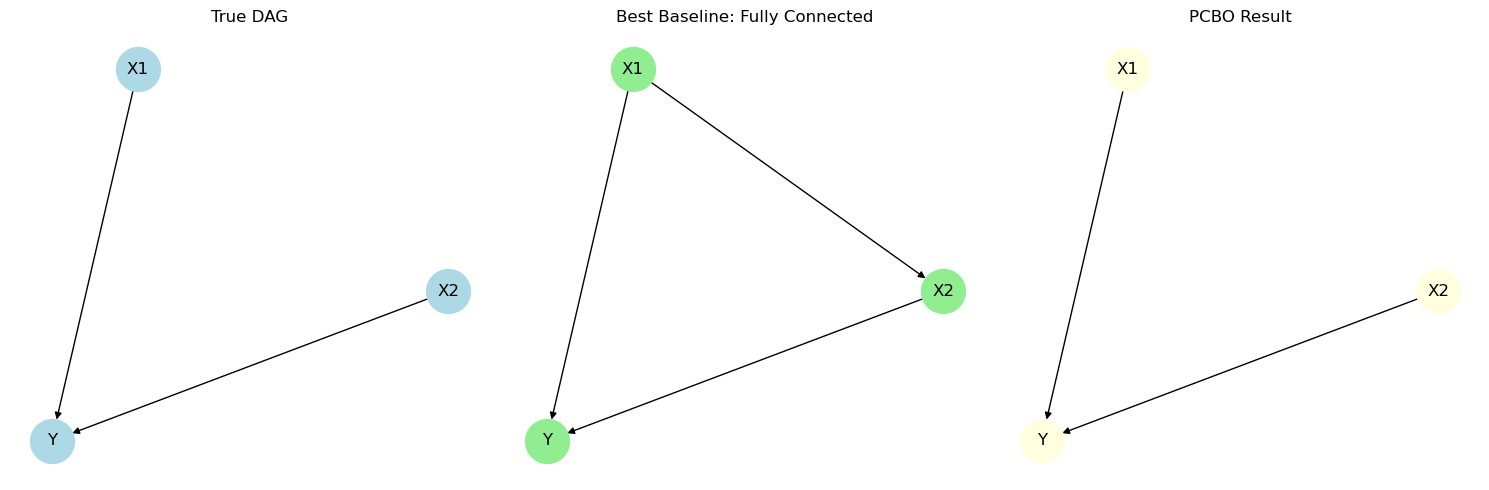

In [38]:
# --- Build learned adjacency from PCBO (works for 3-node or 6-node versions) ---
def learned_adj_from_pcbo(pcbo, true_adj, mode="threshold", thr=0.5):
    A = torch.zeros_like(true_adj)

    if hasattr(pcbo, "local_posts"):  # 6-node version
        if mode == "map":
            for lp in pcbo.local_posts.values():
                mask, _ = lp.most_probable_set()
                for j, is_parent in enumerate(mask):
                    if is_parent:
                        src = lp.parent_idx[j]
                        A[src, lp.target_idx] = 1
        else:  # threshold on edge marginals
            for lp in pcbo.local_posts.values():
                p = lp.edge_posterior()  # (d_parents,)
                for j, src in enumerate(lp.parent_idx):
                    if float(p[j]) >= thr:
                        A[src, lp.target_idx] = 1

    elif hasattr(pcbo, "parent_posterior"):  # 3-node version (only parents of Y)
        tgt = pcbo.parent_posterior.target_idx  # should be 2 (Y)
        if mode == "map":
            mask, _ = pcbo.parent_posterior.most_probable_set()  # tuple of length 2
            for i, is_parent in enumerate(mask):
                if is_parent:
                    A[i, tgt] = 1
        else:
            p = pcbo.parent_posterior.edge_posterior()  # tensor length 2
            for i in range(p.numel()):
                if float(p[i]) >= thr:
                    A[i, tgt] = 1
    else:
        raise ValueError("PCBO object has neither local_posts nor parent_posterior.")

    # no self loops
    A.fill_diagonal_(0)
    return A

# --- Plot true, best baseline, and PCBO learned graph ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1) True graph
ax = axes[0]
G_true = nx.DiGraph(true_adj.numpy())
pos = nx.spring_layout(G_true, seed=42)
nx.draw(G_true, pos, ax=ax, with_labels=True,
        labels={i: node_names[i] for i in range(true_adj.shape[0])},
        node_color='lightblue', node_size=1000, font_size=12)
ax.set_title("True DAG")

# 2) Best baseline
ax = axes[1]
G_baseline = nx.DiGraph(best_baseline[1]['adj'])
nx.draw(G_baseline, pos, ax=ax, with_labels=True,
        labels={i: node_names[i] for i in range(true_adj.shape[0])},
        node_color='lightgreen', node_size=1000, font_size=12)
ax.set_title(f"Best Baseline: {best_baseline[0]}")

# 3) PCBO learned graph (choose mode="threshold" or "map")
learned_adj = learned_adj_from_pcbo(pcbo, true_adj, mode="threshold", thr=0.5)
G_pcbo = nx.DiGraph(learned_adj.numpy())
ax = axes[2]
nx.draw(G_pcbo, pos, ax=ax, with_labels=True,
        labels={i: node_names[i] for i in range(true_adj.shape[0])},
        node_color='lightyellow', node_size=1000, font_size=12)
ax.set_title("PCBO Result")

plt.tight_layout()
plt.show()

## Visualize Results

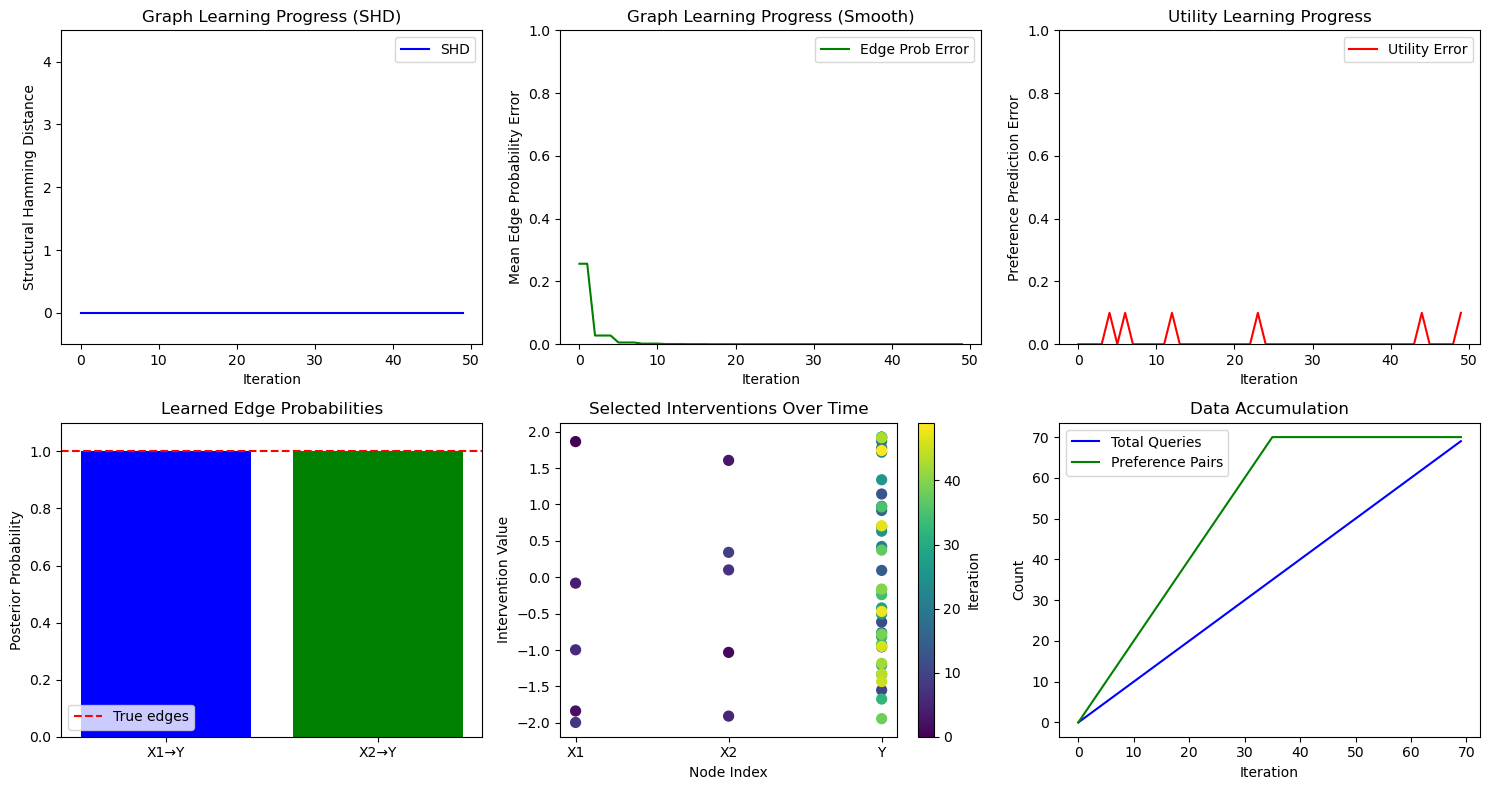

In [39]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 1. Graph Learning Progress (SHD)
axes[0, 0].plot(pcbo.iteration_history, pcbo.graph_distances, 'b-', label='SHD')
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("Structural Hamming Distance")
axes[0, 0].set_title("Graph Learning Progress (SHD)")
axes[0, 0].set_ylim([-0.5, 4.5])
axes[0, 0].legend()

# 2. Edge Probability Error (Smoother metric)
axes[0, 1].plot(pcbo.iteration_history, pcbo.edge_prob_errors, 'g-', label='Edge Prob Error')
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("Mean Edge Probability Error")
axes[0, 1].set_title("Graph Learning Progress (Smooth)")
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()

# 3. Utility Learning Progress
axes[0, 2].plot(pcbo.iteration_history, pcbo.utility_errors, 'r-', label='Utility Error')
axes[0, 2].set_xlabel("Iteration")
axes[0, 2].set_ylabel("Preference Prediction Error")
axes[0, 2].set_title("Utility Learning Progress")
axes[0, 2].set_ylim([0, 1])
axes[0, 2].legend()

# 4. Final Edge Probabilities
edge_probs = pcbo.parent_posterior.edge_posterior().numpy()
axes[1, 0].bar(['X1→Y', 'X2→Y'], edge_probs, color=['blue', 'green'])
axes[1, 0].axhline(y=1.0, color='r', linestyle='--', label='True edges')
axes[1, 0].set_ylabel("Posterior Probability")
axes[1, 0].set_title("Learned Edge Probabilities")
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].legend()

# 5. Selected Interventions Over Time
interventions_array = np.array(pcbo.selected_interventions)
scatter = axes[1, 1].scatter(interventions_array[:, 0], interventions_array[:, 1], 
                            c=range(len(interventions_array)), cmap='viridis', s=50)
axes[1, 1].set_xlabel("Node Index")
axes[1, 1].set_ylabel("Intervention Value")
axes[1, 1].set_title("Selected Interventions Over Time")
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].set_xticklabels(['X1', 'X2', 'Y'])
plt.colorbar(scatter, ax=axes[1, 1], label='Iteration')

# 6. Preference Dataset Growth
axes[1, 2].plot(range(len(all_queries)), [i for i in range(len(all_queries))], 'b-', label='Total Queries')
axes[1, 2].plot(range(len(all_queries)), [min(i*2, len(pcbo.pref_dataset)) for i in range(len(all_queries))], 
               'g-', label='Preference Pairs')
axes[1, 2].set_xlabel("Iteration")
axes[1, 2].set_ylabel("Count")
axes[1, 2].set_title("Data Accumulation")
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## Final Results and Analysis


FINAL RESULTS

True causal graph:
[[0 0 1]
 [0 0 1]
 [0 0 0]]

Most probable parent set for Y: (1, 1)
Posterior probability: 1.000

Edge posterior probabilities:
  P(X1 → Y) = 1.000 (True: 1.0)
  P(X2 → Y) = 1.000 (True: 1.0)

Final metrics:
  SHD: 0.00
  Edge probability error: 0.000
  Utility prediction error: 0.100

Learning efficiency:
  Total queries: 70
  Total preference comparisons: 70
  Flow reinitializations: 0

Visualization of learned causal structure:


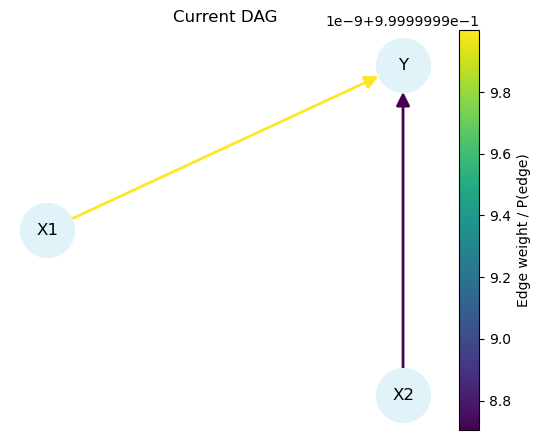


PCBO COMPLETE


In [40]:
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

print(f"\nTrue causal graph:")
print(f"{true_adj.numpy()}")

most_prob_parents, prob = pcbo.parent_posterior.most_probable_set()
print(f"\nMost probable parent set for Y: {most_prob_parents}")
print(f"Posterior probability: {prob:.3f}")

edge_probs = pcbo.parent_posterior.edge_posterior()
print(f"\nEdge posterior probabilities:")
print(f"  P(X1 → Y) = {edge_probs[0]:.3f} (True: 1.0)")
print(f"  P(X2 → Y) = {edge_probs[1]:.3f} (True: 1.0)")

print(f"\nFinal metrics:")
print(f"  SHD: {pcbo.graph_distances[-1]:.2f}")
print(f"  Edge probability error: {pcbo.edge_prob_errors[-1]:.3f}")
print(f"  Utility prediction error: {pcbo.utility_errors[-1]:.3f}")

print(f"\nLearning efficiency:")
print(f"  Total queries: {len(all_queries)}")
print(f"  Total preference comparisons: {len(pcbo.pref_dataset)}")
print(f"  Flow reinitializations: {pcbo.reinitialization_count}")

# Visualize final learned causal structure
learned_adj = torch.zeros_like(true_adj)
for i, is_parent in enumerate(most_prob_parents):
    if is_parent:
        learned_adj[i, 2] = 1

print("\nVisualization of learned causal structure:")
plot_dag(learned_adj.numpy(), names=node_names, edge_probs=edge_probs.numpy())

print("\n" + "="*50)
print("PCBO COMPLETE")
print("="*50)